<a href="https://colab.research.google.com/github/gbouzioto/chemical_polution/blob/main/notebooks/model_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Statements

In [4]:
import os
import numpy
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from tensorflow.keras.applications import InceptionV3, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import get_file
from tensorflow import expand_dims
from tensorflow.nn import softmax

from sklearn.metrics import classification_report, confusion_matrix

## Load Dataset

In [6]:
project_dir = os.path.join('C:/Users/Nikiforos/anaconda3/', 'content')
dataset_file = os.path.join(project_dir, 'BlackSea.zip')
dataset_file_path = os.path.join(project_dir, 'BlackSea')

if not os.path.isdir(dataset_file_path):
    # download dataset if it does not exist
    url = 'http://dsfp.chem.uoa.gr/BlackSea/Predicted%20spatial%20distribution%20dataset.zip'
    urllib.request.urlretrieve(url, dataset_file)
    # extract images
    with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_file_path)

dataset_train = os.path.join(dataset_file_path, 'train')
dataset_evaluation = os.path.join(dataset_file_path, 'evaluation')

## Data Augmentation

### Train and Validation Generators

In [7]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [8]:
train_generator = train_datagen.flow_from_directory(
    dataset_train, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_train, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation')

Found 1126 images belonging to 3 classes.
Found 280 images belonging to 3 classes.


### Evaluation generator

In [9]:
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [10]:
test_generator = test_datagen.flow_from_directory(
        dataset_evaluation,
        target_size=(150, 150),
        shuffle = False,
        class_mode='categorical',
        batch_size=32)

Found 224 images belonging to 3 classes.


In [11]:
test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
print(test_steps_per_epoch)

7


# Baseline model implementation

Set the architecture of the neural network model

In [12]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1500, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

Set the loss and the optimizer function

In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
36/36 [==============================] - 25s 687ms/step - loss: 52.2253 - accuracy: 0.4831 - val_loss: 5.4275 - val_accuracy: 0.7964
Epoch 2/5
36/36 [==============================] - 24s 655ms/step - loss: 2.9945 - accuracy: 0.7336 - val_loss: 0.4661 - val_accuracy: 0.9357
Epoch 3/5
36/36 [==============================] - 26s 732ms/step - loss: 1.2240 - accuracy: 0.8526 - val_loss: 0.1565 - val_accuracy: 0.9679
Epoch 4/5
36/36 [==============================] - 26s 734ms/step - loss: 1.0188 - accuracy: 0.8561 - val_loss: 0.2138 - val_accuracy: 0.9679
Epoch 5/5
36/36 [==============================] - 22s 623ms/step - loss: 1.0676 - accuracy: 0.8766 - val_loss: 0.1725 - val_accuracy: 0.9821


In [15]:
test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        dataset_evaluation,
        target_size=(150, 150),
        shuffle = False,
        class_mode='categorical',
        batch_size=32)

Found 224 images belonging to 3 classes.


In [16]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.29153162240982056
Test accuracy: 0.96875


### Classification Report and Confusion Matrix Results

               precision    recall  f1-score   support

       Danube       1.00      0.99      1.00       109
      Dnieper       0.92      1.00      0.96        78
UnknownOrigin       1.00      0.84      0.91        37

     accuracy                           0.97       224
    macro avg       0.97      0.94      0.95       224
 weighted avg       0.97      0.97      0.97       224



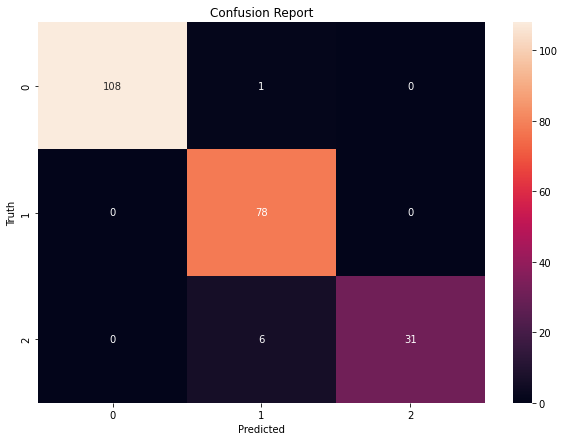

In [17]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()

# Transfer learning

## ResNet50

### Initialization and Summary

In [ ]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add a dropout layer
x = Dropout(0.2)(x)
# and a logistic layer -- we have 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Model Training

In [ ]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1126//32,
    epochs=14,
    validation_steps=280//32)

Epoch 1/14
35/35 [==============================] - 30s 790ms/step - loss: 1.0122 - accuracy: 0.5338 - val_loss: 0.8317 - val_accuracy: 0.6367
Epoch 2/14
35/35 [==============================] - 26s 748ms/step - loss: 0.7628 - accuracy: 0.7349 - val_loss: 0.7381 - val_accuracy: 0.6094
Epoch 3/14
35/35 [==============================] - 26s 744ms/step - loss: 0.6284 - accuracy: 0.8035 - val_loss: 0.5965 - val_accuracy: 0.9102
Epoch 4/14
35/35 [==============================] - 26s 740ms/step - loss: 0.4988 - accuracy: 0.8565 - val_loss: 0.4244 - val_accuracy: 0.8672
Epoch 5/14
35/35 [==============================] - 26s 744ms/step - loss: 0.4386 - accuracy: 0.8565 - val_loss: 0.3724 - val_accuracy: 0.9258
Epoch 6/14
35/35 [==============================] - 26s 742ms/step - loss: 0.3496 - accuracy: 0.8967 - val_loss: 0.3009 - val_accuracy: 0.8906
Epoch 7/14
35/35 [==============================] - 26s 749ms/step - loss: 0.3159 - accuracy: 0.9113 - val_loss: 0.2576 - val_accuracy: 0.9258

### Model Accuracy

In [ ]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2832943797111511
Test accuracy: 0.8616071343421936


### Classification Report and Confusion Matrix Results

               precision    recall  f1-score   support

       Danube       0.89      1.00      0.94       109
      Dnieper       0.82      1.00      0.90        78
UnknownOrigin       1.00      0.16      0.28        37

     accuracy                           0.86       224
    macro avg       0.90      0.72      0.71       224
 weighted avg       0.88      0.86      0.82       224



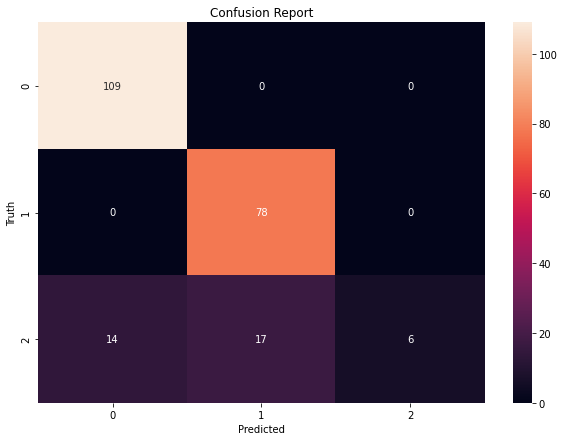

In [ ]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()


## InceptionV3

### Initialization and Summary

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add a dropout layer
x = Dropout(0.2)(x)
# and a logistic layer -- we have 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
___________________________

### Model Training

In [ ]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1126//32,
    epochs=5,
    validation_steps=280//32)

Epoch 1/5
35/35 [==============================] - 31s 771ms/step - loss: 1.1153 - accuracy: 0.6746 - val_loss: 0.3353 - val_accuracy: 0.8945
Epoch 2/5
35/35 [==============================] - 26s 733ms/step - loss: 0.2571 - accuracy: 0.9333 - val_loss: 0.1917 - val_accuracy: 0.9414
Epoch 3/5
35/35 [==============================] - 26s 738ms/step - loss: 0.2115 - accuracy: 0.9287 - val_loss: 0.1302 - val_accuracy: 0.9570
Epoch 4/5
35/35 [==============================] - 25s 729ms/step - loss: 0.1600 - accuracy: 0.9543 - val_loss: 0.1688 - val_accuracy: 0.9492
Epoch 5/5
35/35 [==============================] - 26s 733ms/step - loss: 0.1605 - accuracy: 0.9506 - val_loss: 0.1190 - val_accuracy: 0.9570


### Model Accuracy

In [ ]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03664422780275345
Test accuracy: 0.9910714030265808


### Classification Report and Confusion Matrix Results

               precision    recall  f1-score   support

       Danube       0.98      1.00      0.99       109
      Dnieper       1.00      0.97      0.99        78
UnknownOrigin       1.00      1.00      1.00        37

     accuracy                           0.99       224
    macro avg       0.99      0.99      0.99       224
 weighted avg       0.99      0.99      0.99       224



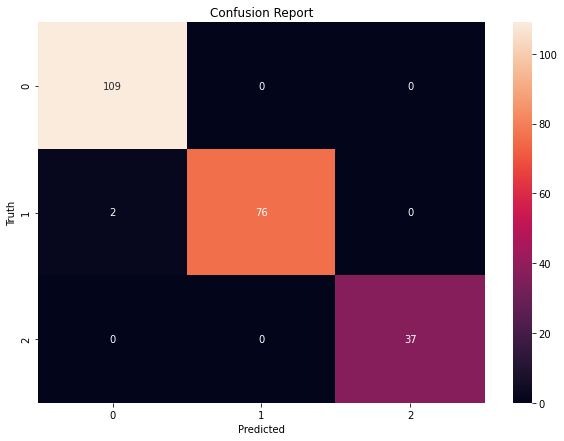

In [ ]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()

## MobileNetV2

### Initialization and Summary

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
base_model.trainable = False

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# add a dropout layer
x = Dropout(0.2)(x)
# and a logistic layer -- we have 3 classes
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
_____________________________

### Model Training

In [ ]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=1126//32,
    epochs=9,
    validation_steps=280//32)

Epoch 1/9
35/35 [==============================] - 29s 763ms/step - loss: 0.4266 - accuracy: 0.8912 - val_loss: 0.0344 - val_accuracy: 0.9922
Epoch 2/9
35/35 [==============================] - 25s 724ms/step - loss: 0.1032 - accuracy: 0.9771 - val_loss: 0.1260 - val_accuracy: 0.9648
Epoch 3/9
35/35 [==============================] - 25s 711ms/step - loss: 0.1093 - accuracy: 0.9726 - val_loss: 0.0133 - val_accuracy: 0.9961
Epoch 4/9
35/35 [==============================] - 25s 713ms/step - loss: 0.0866 - accuracy: 0.9753 - val_loss: 0.2561 - val_accuracy: 0.8984
Epoch 5/9
35/35 [==============================] - 25s 711ms/step - loss: 0.0968 - accuracy: 0.9735 - val_loss: 0.1049 - val_accuracy: 0.9570
Epoch 6/9
35/35 [==============================] - 25s 713ms/step - loss: 0.0909 - accuracy: 0.9735 - val_loss: 0.0363 - val_accuracy: 0.9883
Epoch 7/9
35/35 [==============================] - 25s 714ms/step - loss: 0.0846 - accuracy: 0.9781 - val_loss: 0.0219 - val_accuracy: 0.9922
Epoch 

### Model Accuracy

In [ ]:
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.20453548431396484
Test accuracy: 0.9285714030265808


### Classification Report and Confusion Matrix Results

               precision    recall  f1-score   support

       Danube       1.00      0.85      0.92       109
      Dnieper       1.00      1.00      1.00        78
UnknownOrigin       0.70      1.00      0.82        37

     accuracy                           0.93       224
    macro avg       0.90      0.95      0.91       224
 weighted avg       0.95      0.93      0.93       224



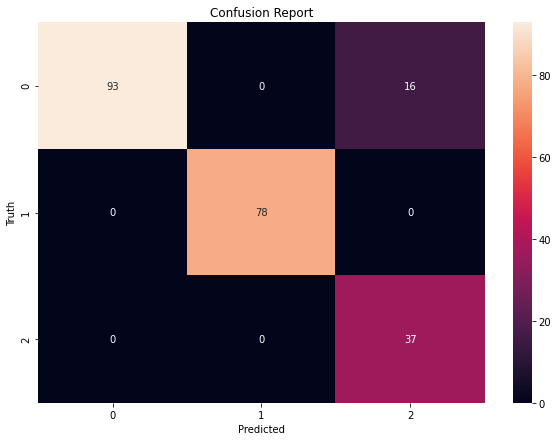

In [ ]:
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)
print(report)
cmrforest = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cmrforest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Report')
plt.show()